# K\-Nearest Neighbors



In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from modeling_data import Data_Import
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
# Inline plots
%matplotlib inline
# Progress bars for pandas
tqdm.pandas()

In [3]:
# Create the data
data = Data_Import()

## Feature Selection

First, I will check if any of the non n\-gram features should be dropped.



In [4]:
# Combinations of first 3 features
import itertools
features = ["index_of_dispersion_norm","avg_cong_chars","capital_ratio"]
results = []

for c in tqdm(range(0,3)):
    combinations = list(itertools.combinations(features,c))
    for combination in combinations:
        knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-4,weights='distance')
        data.split_data(limit_ngrams=0, drop_features=list(combination))
        knn.fit(data.X_train, data.y_train)
        yhat = knn.predict(data.X_test)
        results.append((list(combination),accuracy_score(data.y_test,yhat)))

results = sorted(results, key=lambda x: x[1], reverse=True)
for (comb,acc) in results:
    print("Dropped Features: {} Accuracy: {}".format(comb, acc))
    
best_drop_comb = results[0][0]
if len(best_drop_comb)==0:
    print("Best accuracy is with no features dropped")
else:
    print("Best accuracy is with features {} dropped".format(best_drop_comb))

  0%|          | 0/3 [00:00<?, ?it/s]

Dropped Features: [] Accuracy: 0.12874418604651164
Dropped Features: ['capital_ratio'] Accuracy: 0.09562790697674418
Dropped Features: ['index_of_dispersion_norm'] Accuracy: 0.08995348837209302
Dropped Features: ['avg_cong_chars'] Accuracy: 0.08009302325581395
Dropped Features: ['index_of_dispersion_norm', 'capital_ratio'] Accuracy: 0.061674418604651164
Dropped Features: ['avg_cong_chars', 'capital_ratio'] Accuracy: 0.05916279069767442
Dropped Features: ['index_of_dispersion_norm', 'avg_cong_chars'] Accuracy: 0.04469767441860465
Best accuracy is with no features dropped


It looks like all of the first three features help improve the accuracy of the model. Now, I will find the test accuracy of the model with increasing n\-gram features.


In [5]:
train_acc = []
test_acc = []

allns = list(range(1, 46, 10)) + [46]

for n in tqdm(allns):
    knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-4,weights='distance')
    data.split_data(limit_ngrams=n)
    knn.fit(data.X_train, data.y_train)
    yhat_train = knn.predict(data.X_train)
    yhat = knn.predict(data.X_test)
    train_acc.append(accuracy_score(data.y_train,yhat_train))
    test_acc.append(accuracy_score(data.y_test,yhat))

  0%|          | 0/6 [00:00<?, ?it/s]

Highest accuracy is 0.34413953488372095 with 46 ngram features


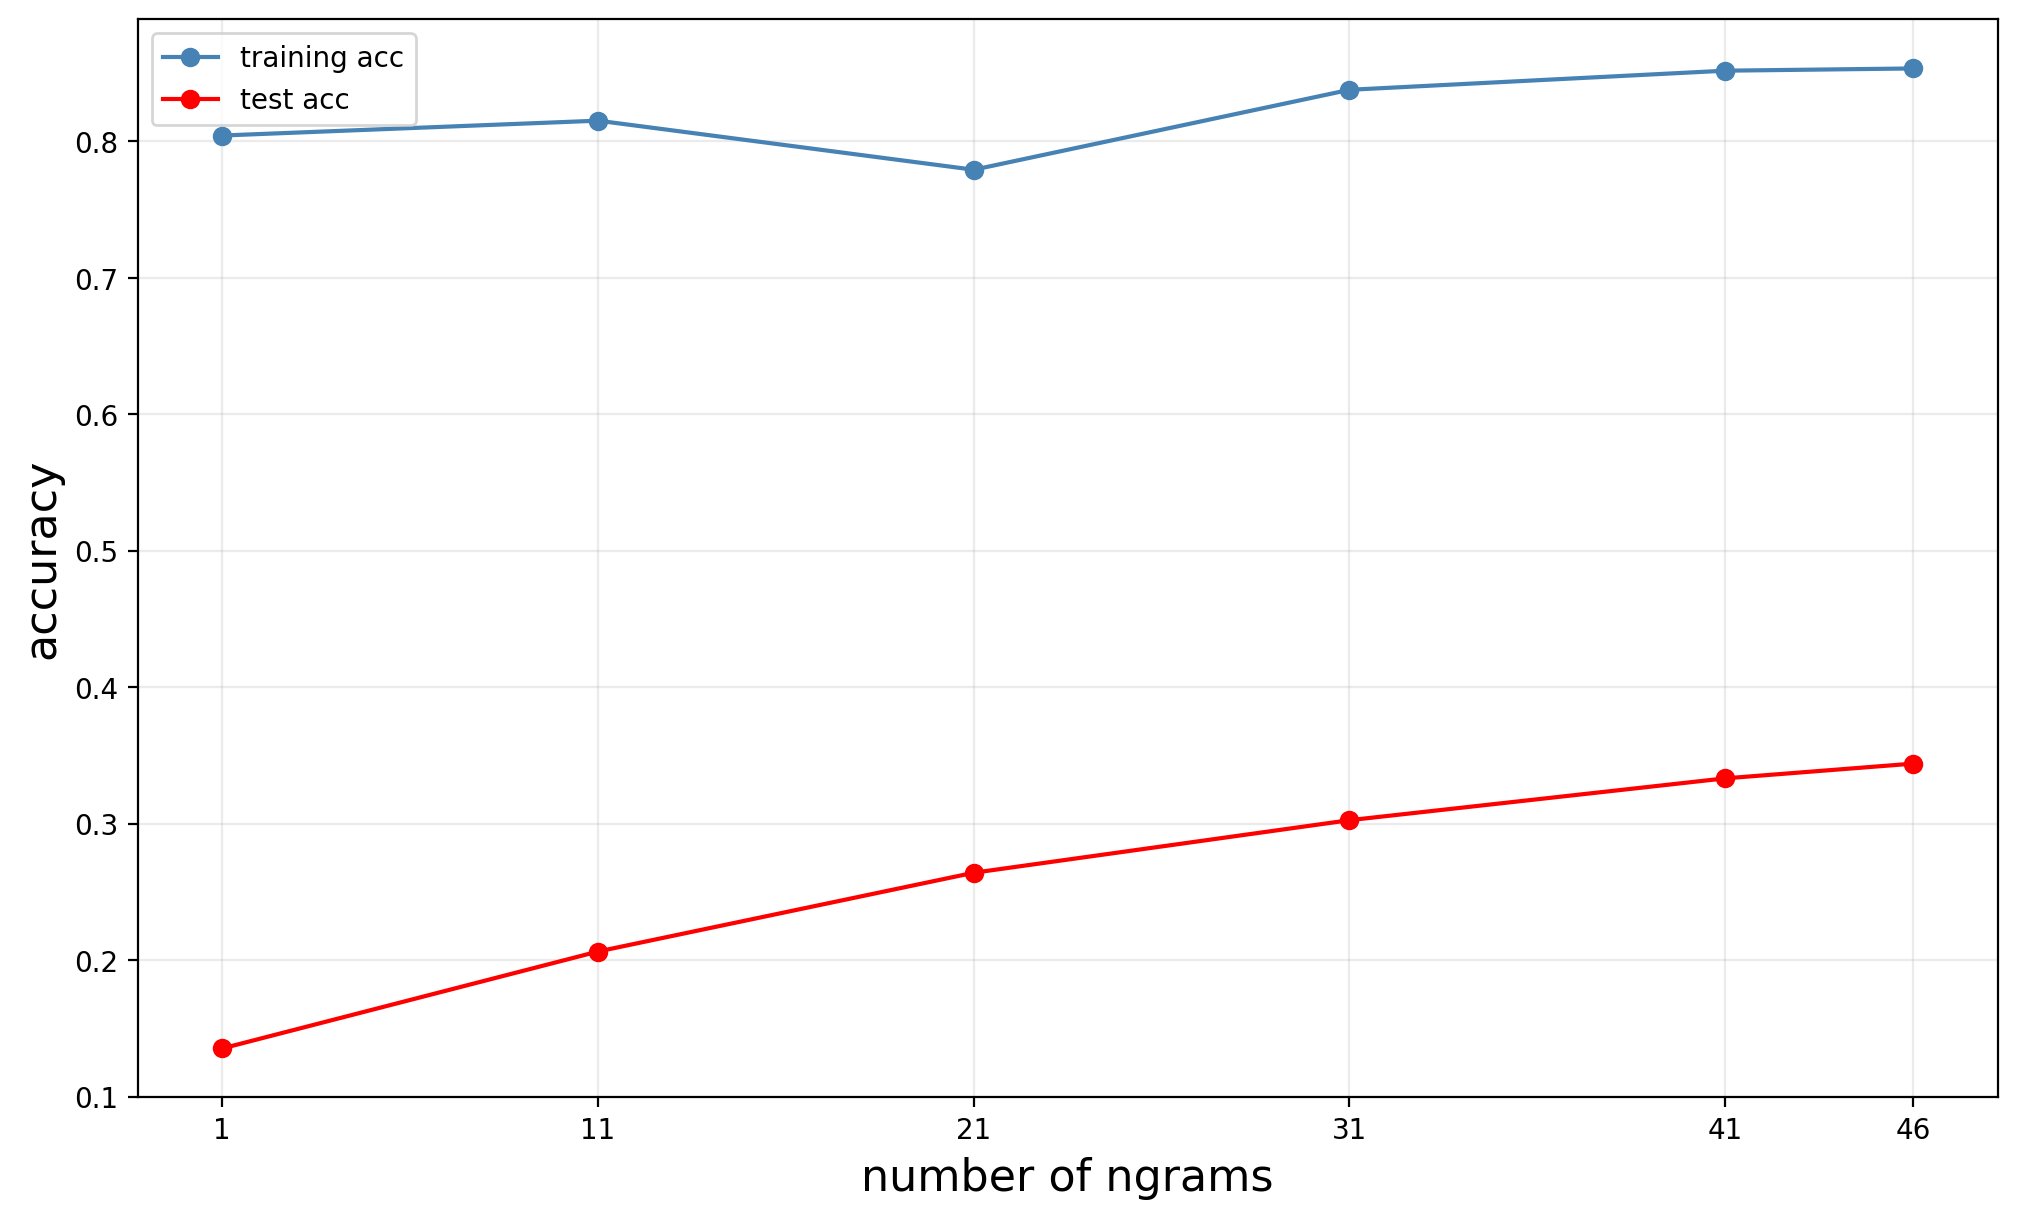

In [6]:
# Plot the accuracies
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allns, train_acc, marker="o", color="steelblue", label="training acc")
ax.plot(allns, test_acc, marker="o", color="red", label="test acc")
ax.set_xlabel("number of ngrams", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
leg = plt.legend()
plt.xticks(allns)
ax.grid(alpha=0.25)

highest_acc_ind = np.argmax(test_acc)
print("Highest accuracy is {} with {} ngram features".format(test_acc[highest_acc_ind], allns[highest_acc_ind]))

The test accuracy is highest when I use all of the n\-gram features.


## Hyperparameter Tuning

First I will determine if the weight function should be uniform or distance. Uniform weights weigh all of the neighbors equally, while distance weights gives more influence to neighbors closer to the query point.


In [7]:
data.split_data()
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-4)
knn.fit(data.X_train, data.y_train)
yhat_train = knn.predict(data.X_train)
yhat = knn.predict(data.X_test)
print("Uniform weights test accuracy {}".format(accuracy_score(data.y_test,yhat)))
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-4,weights='distance')
knn.fit(data.X_train, data.y_train)
yhat_train = knn.predict(data.X_train)
yhat = knn.predict(data.X_test)
print("Distance weights test accuracy {}".format(accuracy_score(data.y_test,yhat)))

Uniform weights test accuracy 0.34255813953488373


Distance weights test accuracy 0.35074418604651164


Now I will test the model with varying values for n\_neighbors. First, I will do a large range with a large step, then I will narrow down the range and use a step of 1.


In [14]:
train_acc = []
test_acc = []
allks = list(range(1, 101, 5))

for k in tqdm(allks):
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-4,weights='distance')
    knn.fit(data.X_train, data.y_train)
    yhat_train = knn.predict(data.X_train)
    yhat = knn.predict(data.X_test)
    train_acc.append(accuracy_score(data.y_train,yhat_train))
    test_acc.append(accuracy_score(data.y_test,yhat))

  0%|          | 0/20 [00:00<?, ?it/s]

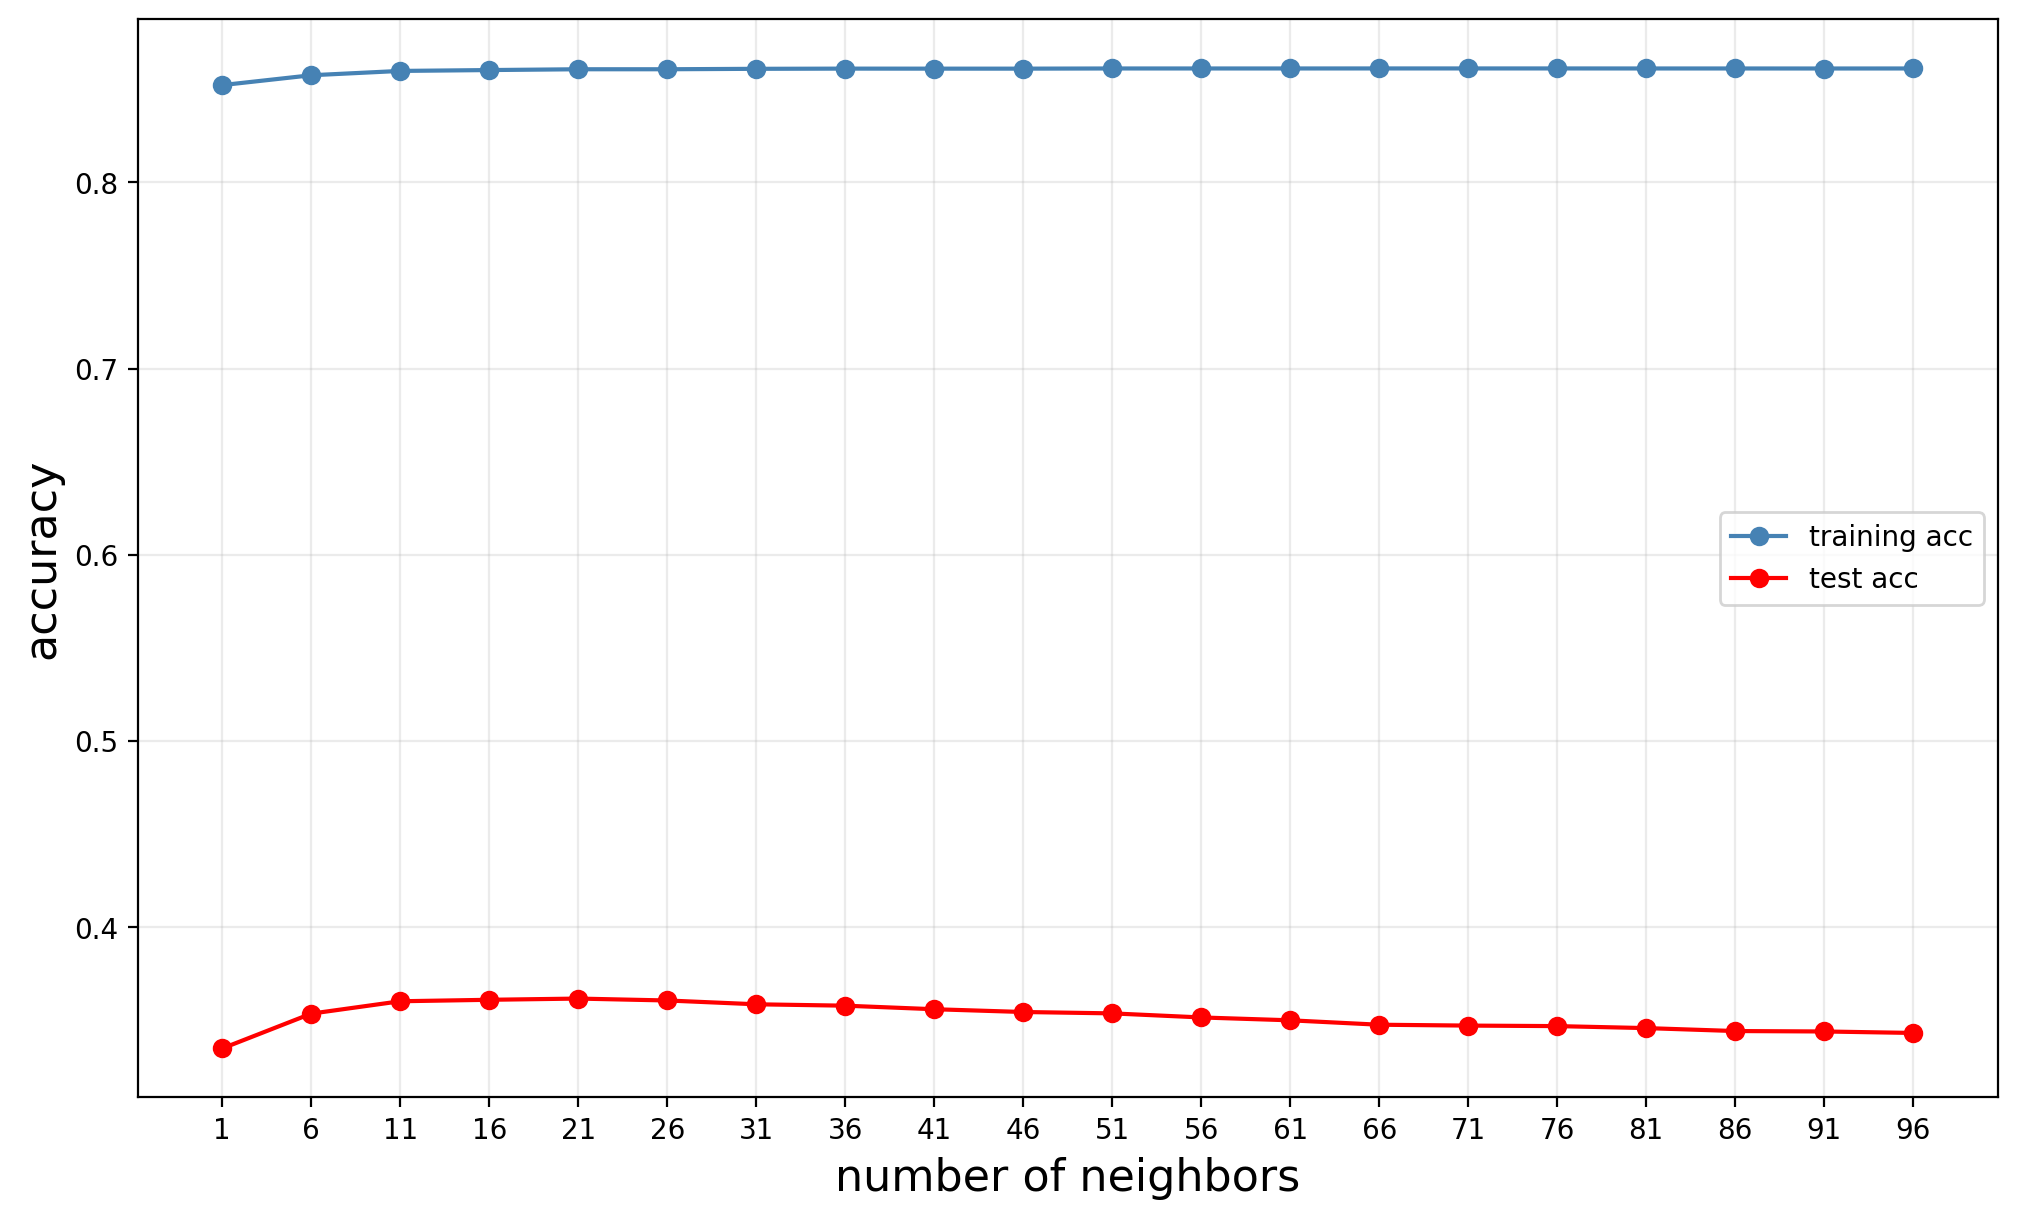

In [15]:
# Plot the accuracies
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, train_acc, marker="o", color="steelblue", label="training acc")
ax.plot(allks, test_acc, marker="o", color="red", label="test acc")
ax.set_xlabel("number of neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
leg = plt.legend()
plt.xticks(allks)
ax.grid(alpha=0.25)

highest_acc_ind = np.argmax(test_acc)

In [16]:
best_test_acc = 0
best_k = 0
best_model = None

for k in tqdm(range(16, 26, 1)):
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-4, weights='distance')
    knn.fit(data.X_train, data.y_train)
    yhat = knn.predict(data.X_test)
    test_acc = accuracy_score(data.y_test,yhat)
    if test_acc >= best_test_acc:
        best_test_acc = test_acc
        best_k = k
        best_model = knn

print("Best k is {} with accuracy {}".format(best_k, best_test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Best k is 22 with accuracy 0.36153488372093023


## Analysis

Now that I have determined that the best model includes all of my features and uses a k value of 17, I will create some visualizations to help with analysis.



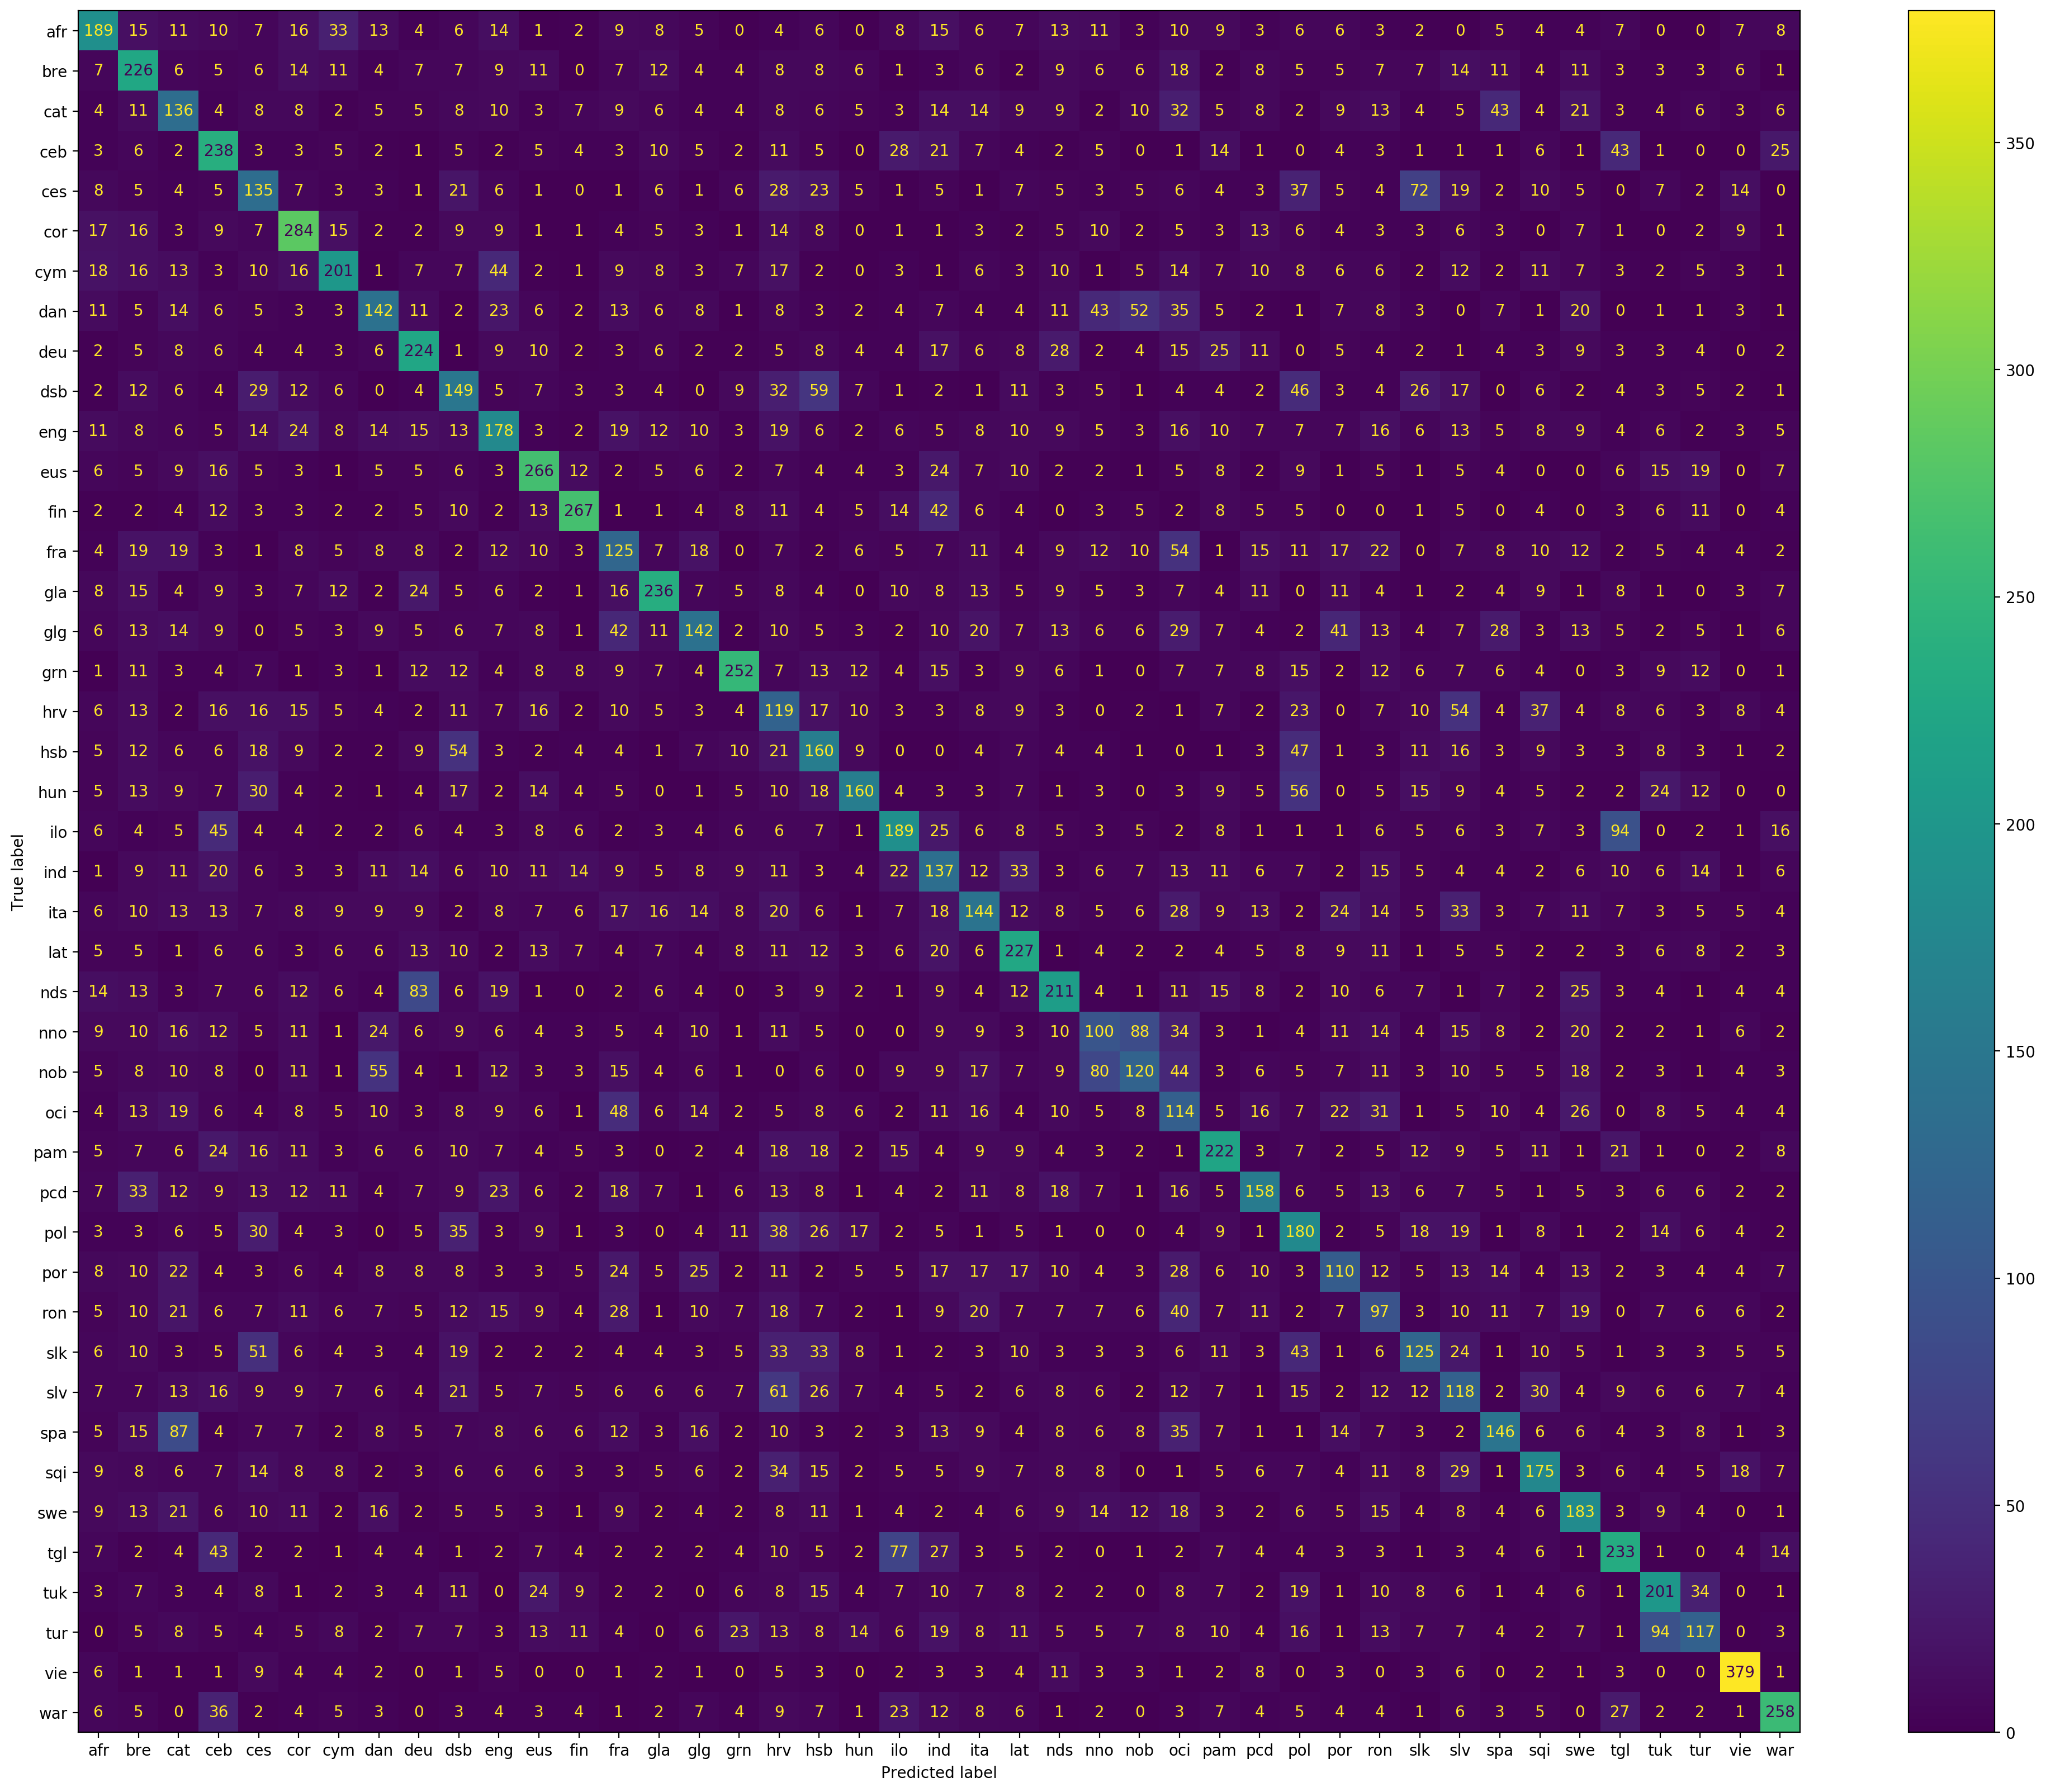

In [11]:
# Confusion Matrix of best model
fig, ax = plt.subplots(figsize=(25, 20))
y_pred = best_model.predict(data.X_test)
labels = data.le.inverse_transform(best_model.classes_)
disp = ConfusionMatrixDisplay.from_predictions(data.y_test, y_pred, labels=best_model.classes_, display_labels=labels, ax=ax)
plt.show()

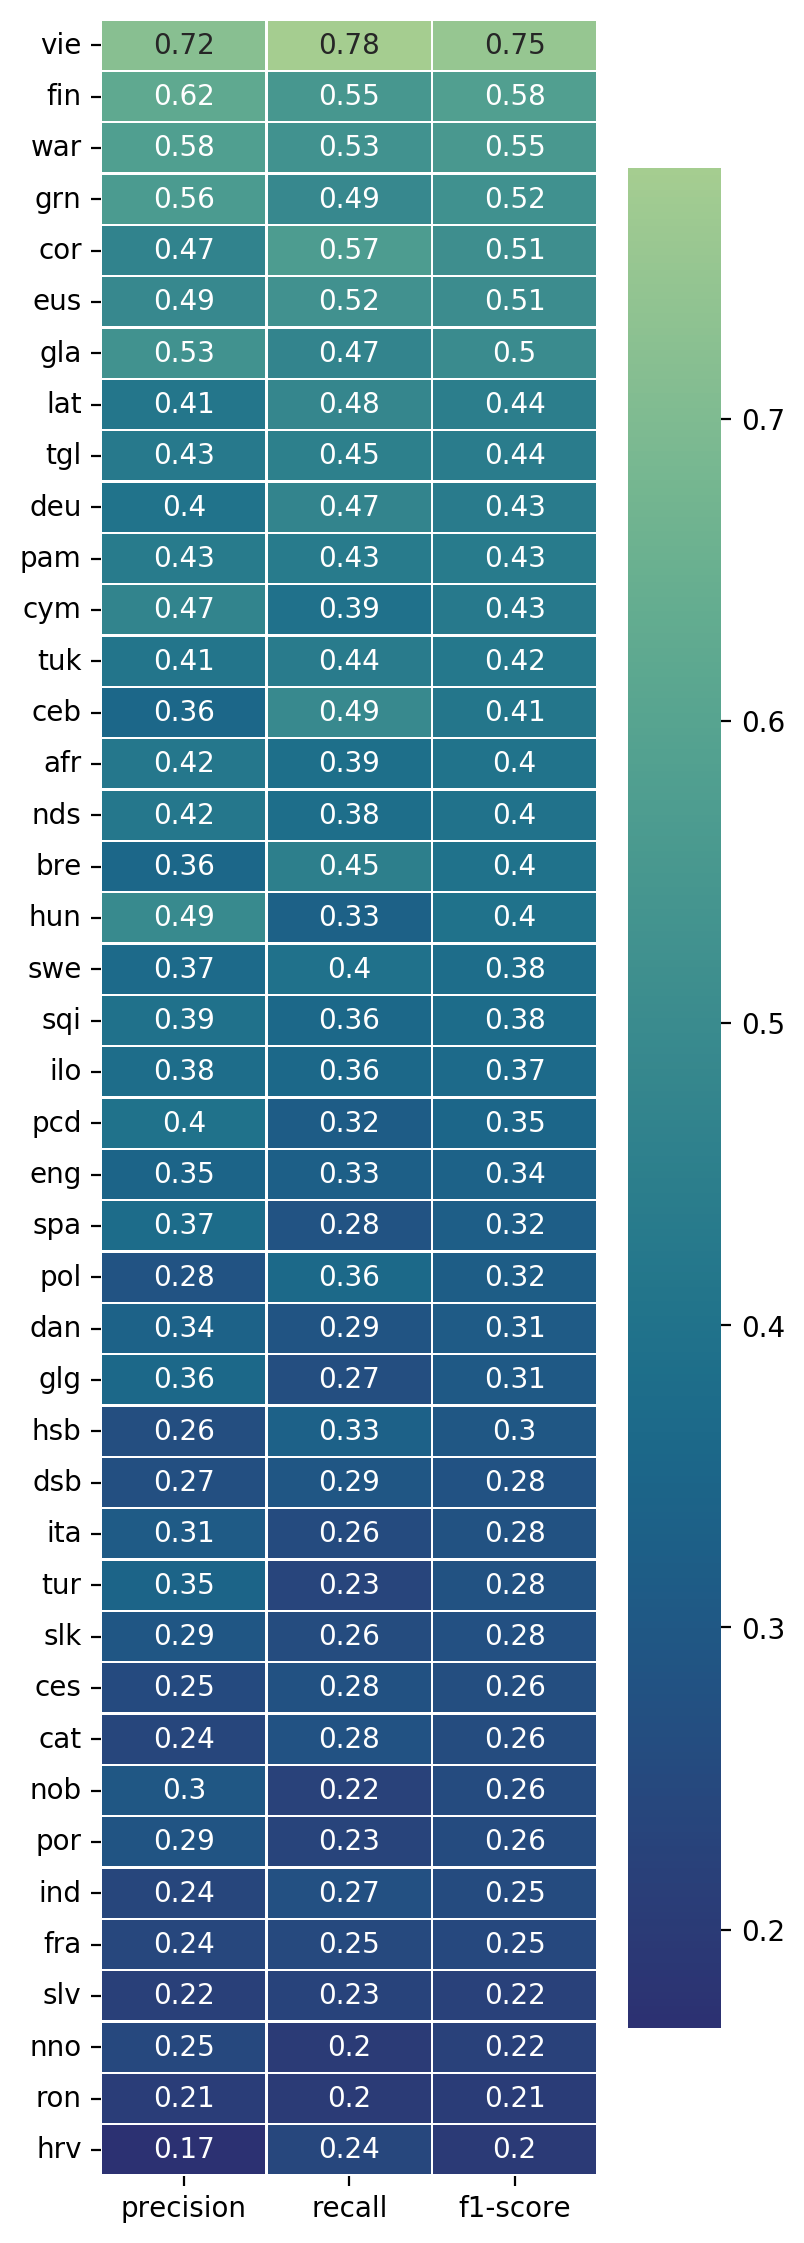

In [12]:
# Classification Report
report = classification_report(data.y_test, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose().sort_values("f1-score",ascending=False)
report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
report_df.drop(["support"], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(4,14)) 
sns.heatmap(pd.DataFrame(report_df).iloc[:-1, :], annot=True, linewidths=.5,ax=ax,cmap="crest_r")